# Hinge Data Challenge
### by Stella Wang

In this project, we will answer four questions in the Hinge Data Challenge sequentially. 

## Table of contents
- [Question 1](#Question1)
- [Question 2](#Question2)
- [Question 3](#Question3)
- [Question 4](#Question4)

----
<a id='Question1'></a>
## Question 1
Using only information in the datasets provided, how would you define the next-day retention rate of new users? (We will henceforth call this “retention rate.”) State your definition in a way that someone else can compute the metric unambiguously, and provide your reasoning for your approach.

[[ go back to the top ]](#Table-of-contents)

There are two ways to define the `next-day retention rate`. One is through calculating it using a 24 hours window, another by strict calendar date. <br>

For example, when calculating by 24 hours window, if a user registration date was `2018-11-13 23:10:00`, we count `2018-11-13 23:10:00 ~ 2018-11-14 23:10:00` as the Day 0, and the next-day from `2018-11-15 23:10:00 ~ 2018-11-16 23:10:00 ` (as Day1). <br>

If we calculate by strict calendar date, it means `2018-11-13` is the Day 0 even though `2018-11-13 23:10:00` is almost the end of the day, and `2018-11-14` is the next-day time range. When time sensitive, we should use strict calendar date because it only takes 24 hours to get the data. 

In this analysis, let's assume we wanted to get an accurate `next-day retention rate` and we can afford waiting for two days to get retention rate. 



Assumption:
- Assume `active user` is defined as an user who has a rating record, it doesn't matter if the user is sending likes or skips 
- Assume `Number of new user in a given date` means number of users who registered the app on a given date
- The `next day retention rate` is calculated by 24 hours window.

<b> Next-day retention rate = Number of unique users who were active on the next day / Number of unique new users in a given date </b>

For example, if we have next-day retention rate = 10% on 2018-11-13, and we assume there were 1000 of users who registered on that day. 10% of next-day retention rate means out of 1000 new users who registered on 2018-11-13, 100 came back and triggered some rating event between 24th ~ 48th hour after their respective registration timestamp.

In [1]:
#import packages necessary for this project 
import pandas as pd
import numpy as np 
from datetime import date, datetime, timedelta
from scipy import stats
#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8
import matplotlib.ticker as mtick

In [2]:
#import datasets
rating_df = pd.read_csv('ratings.csv', parse_dates = ['ts_minute'])
user_df = pd.read_csv('users.csv', parse_dates = ['registration_ts', 'profile_completion_ts'])

In [11]:
print("Rating dataset has {} data points with {} variables each. See a sample below.".format(*rating_df.shape))
rating_df.head(1)

Rating dataset has 18517862 data points with 4 variables each. See a sample below.


,user_id,rating_type,ts_minute,ct
0,5100,1,2018-10-15 01:55:00,1


In [10]:
print("User dataset has {} data points with {} variables each. See a sample below.".format(*rating_df.shape))
user_df.head(1)

User dataset has 18517862 data points with 4 variables each. See a sample below.


,user_id,platform,registration_ts,profile_completion_ts,gender,gender_preference,photos_count,max_distance,metro_area,age,...,height_pref_max,height_pref_min,height_strict,education_attained,dogs,cats,hobby1,hobby2,hobby3,hobby4
0,59758,Android,2018-10-19 11:46:12,2018-10-19 11:55:46,0.0,2.0,5,14.0,0,19,...,214.0,92.0,0.0,0.0,0.0,3.0,0,0,0,1


----
<a id='Question2'></a>

## Question 2
Hinge’s COO, Sam, claims that retention rates of Android and iOS users are different. Does the data support Sam’s claim? Is the retention rate of users on one platform consistently and statistically lower than that of the other?


[[ go back to the top ]](#Table-of-contents)

### Compute the Retention rates of Android and iOS

Let's assume that the Retention Rate that Sam referred to is the Next-Day Retention Rate in Question 1. We can tell that it is in daily granularity. When we breakdown the daily retention rate by platform, we can get the `average retention rate` by platform </br>

<b>Average Retention Rate of iOS or Android = Sum of Daily Retention Rate / Number of days </b>
</br>

Based on Sam's hypothesis, we can set the null and alternative hypotheses: </br>

$H_{0}$: Average Retention Rate of iOS = Average Retention Rate of Android </br>
$H_{1}$: Average Retention Rate of iOS $\neq$ Average Retention Rate of Android</br>

Since we are comparing two sample mean and population variance is unknown, we should use `Two Sample T-Test` to see if we should reject the null hypothesis. </br>
</br>
Assumption of Two Sample T-Test: </br>
- Two sample are independent
- data in each group follow normal distribution (according to CLT, when sample size is larger than 30, the samples will be normally distributed)
- Two samples have similar variances

In [4]:
user_rating_df = pd.merge(user_df, rating_df, on = 'user_id', how = 'left')

In [5]:
#check if the left join works as expected 
if user_rating_df[user_rating_df.ts_minute.isnull() ].shape[0]>0:
    print('Left join works okay')

Left join works okay


In [6]:
cvr_platform_df =user_rating_df[['user_id', 'platform', 'registration_ts', 'rating_type', 'ts_minute', 'ct']]

In [7]:
#unique value in platform column
cvr_platform_df.platform.unique()

array(['Android', 'iOS', 'ios'], dtype=object)

In [8]:
#Segment the df by platform
cvr_platform_df_iOS = cvr_platform_df[cvr_platform_df.platform.isin(['iOS' , 'ios'])]
cvr_platform_df_And = cvr_platform_df[cvr_platform_df.platform.isin(['Android'])]

In [9]:
if cvr_platform_df_iOS.shape[0] + cvr_platform_df_And.shape[0] == cvr_platform_df.shape[0]:
    print('Filtering by platform works well.')

Filtering by platform works well.


In [10]:
def calculate_retention_rate(input_df):
    reg_df = input_df[['user_id', 'registration_ts']].groupby(by = ['user_id']).min().reset_index()
    #get the time range for D1, users have to have an action between 24 hrs ~ 48 hrs after their registration date 
    reg_df['min_bound'] = reg_df['registration_ts'] + timedelta(hours = 24)
    reg_df['max_bound'] = reg_df['registration_ts'] + timedelta(hours = 48)
    
    temp_df1 = pd.merge(reg_df, input_df[['user_id', 'ts_minute']], how='left', on = 'user_id')
    
    #Users who were active on their Day 1
    temp_df1_return_D1 = temp_df1[(temp_df1.ts_minute >= temp_df1.min_bound) & (temp_df1.ts_minute <= temp_df1.max_bound)]
    
    # Add an indicator column to represent if users are active at their D1 
    temp_df1_return_D1['Day1_active'] = np.where(temp_df1_return_D1['ts_minute'].isnull(), 0, 1)
    
    #select distinct userId and their Day1_active indicator
    temp_df1_return_D1 = temp_df1_return_D1[['user_id', 'Day1_active']].drop_duplicates()
    
    #merge the user daily active indicator with user_registration_date df , we can use it to calculate retention rate later 
    reg_df = pd.merge(left = reg_df, right = temp_df1_return_D1, on = 'user_id', how = 'left')
    
    #generate registration date column 
    reg_df['registration_date']  = reg_df.registration_ts.dt.to_period('D')
    
    #assign 0 to missing value in Day1_active, 0 represents users weren't active on Day 1
    reg_df['Day1_active'] = np.where(reg_df['Day1_active'].isna(), 0,1)
    
    #pivot table to get how many active per day 
    pivot_df = pd.pivot_table(reg_df, 
                   values = 'user_id', index = ['registration_date'], columns = ['Day1_active'], aggfunc=len)
    
    #calculate the daily conversion rate 
    daily_retention  = pivot_df[1] / (pivot_df[0] + pivot_df[1])
    
    #Return the daily retention rate dataframe 
    return daily_retention

In [11]:
iOS_daily_retention = calculate_retention_rate(cvr_platform_df_iOS)
Android_daily_retention = calculate_retention_rate(cvr_platform_df_And)

/var/folders/nk/g_hk0tsd5jsg2r9jfv_rvgfm0000gn/T/ipykernel_48387/2433810996.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df1_return_D1['Day1_active'] = np.where(temp_df1_return_D1['ts_minute'].isnull(), 0, 1)
/var/folders/nk/g_hk0tsd5jsg2r9jfv_rvgfm0000gn/T/ipykernel_48387/2433810996.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df1_return_D1['Day1_active'] = np.where(temp_df1_return_D1['ts_minute'].isnull(), 0, 1)


In [12]:
# Android_daily_retention.mean()
print("Average retention rate for iOS is {a}, and {b} for Android".format(
    a = round(iOS_daily_retention.mean(),2), b = round(Android_daily_retention.mean(),2)))

Average retention rate for iOS is 0.69, and 0.71 for Android


**The Average Retention Rate by platform are computed, we will run Two sample t-test**

$H_{0}$: Average Retention Rate of iOS = Average Retention Rate of Android </br>
$H_{1}$: Average Retention Rate of iOS $\neq$ Average Retention Rate of Android</br>

Before conducting the two-sample T-test, we need to find if the given data groups have the same variance. We can use the ratio of the larger data groups to the smaller data groups and see if it's less than 4:1, if so, we can consider that the given data groups have equal variance. 

In [13]:
if np.var(Android_daily_retention)/np.var(iOS_daily_retention) < 4:
    print('We can assume that the two group have equal variance')
else:
    print('The two groups have unequal variance')

We can assume that the two group have equal variance


In [14]:
stats.ttest_ind(iOS_daily_retention, Android_daily_retention, equal_var = True, alternative= 'two-sided')

Ttest_indResult(statistic=-2.5534181868374723, pvalue=0.013226821891877065)

In [15]:
0.013226821891877065<0.05

True

Since p-value is smaller than 0.05, so we reject the null hypothesis and conclude that we are 95% confident that the Average Retention Rate of iOS and Android are significantly different. To answer Sam's first question, yes, the average retention rate of Android and iOS users are different. 

### Is the retention rate of users on one platform consistently and statistically lower than that of the other?

Since we know that the `Average Retention Rate of Android > Average Retention Rate of iOS`, so I'd set the hypothesis as below </br>

$H_{0}$: Average Retention Rate of Android <= Average Retention Rate of iOS </br>
$H_{1}$: Average Retention Rate of Android > Average Retention Rate of iOS</br>


In [16]:
stats.ttest_ind(Android_daily_retention, iOS_daily_retention,  equal_var = True, alternative= 'greater')

Ttest_indResult(statistic=2.5534181868374723, pvalue=0.0066134109459385325)

In [17]:
0.0066134109459385325<0.05

True

Since p-value is smaller than 0.05, so we reject the null hypothesis. We are 95% confident that the Average Retention Rate of Android is greater than the Average Retention Rate of iOS.

----
<a id='Question3'></a>
## Question 3
If Android/iOS user retention rates are different, what behavioral or demographic insights might explain this difference? </br>
</br>
If Android/iOS user retention rates are not different, what behavioral or demographic factors seem to contribute to retention in general?


[[ go back to the top ]](#Table-of-contents)

In [18]:
#Segment the df by platform
iOS_df = user_rating_df[user_rating_df.platform.isin(['iOS' , 'ios'])]
Android_df = user_rating_df[user_rating_df.platform.isin(['Android'])]

In [19]:
#clean the "platform" column, make ios points to iOS
user_rating_df['platform'] = np.where(user_rating_df['platform'] == 'ios', 'iOS',user_rating_df['platform'])
user_df['platform'] = np.where(user_df['platform'] == 'ios', 'iOS',user_df['platform'])

#### Assign retention indicator to users

In [20]:
user_rating_df.columns

Index(['user_id', 'platform', 'registration_ts', 'profile_completion_ts',
       'gender', 'gender_preference', 'photos_count', 'max_distance',
       'metro_area', 'age', 'age_pref_max', 'age_pref_min', 'age_strict',
       'height', 'height_pref_max', 'height_pref_min', 'height_strict',
       'education_attained', 'dogs', 'cats', 'hobby1', 'hobby2', 'hobby3',
       'hobby4', 'rating_type', 'ts_minute', 'ct'],
      dtype='object')

In [21]:
#each users' unique registration date 
#select user_id , min(registration_ts) from t group by 1 
user_registration_date = user_rating_df[['user_id', 'registration_ts']].groupby(by = ['user_id']).min().reset_index()

user_registration_date['max_bound'] = user_registration_date['registration_ts'] + timedelta(hours = 48)
user_registration_date['min_bound'] = user_registration_date['registration_ts'] + timedelta(hours = 24)

user_registration_date.head()

#select * from user_registration_date left join user_rating_df 
# on t1.user_id = t2.user_id and t2.ts_minutes between t1.min_bound and t1.max_bound 

iOS_And_1 = pd.merge(user_registration_date, user_rating_df[['user_id', 'ts_minute']], how='left', on = 'user_id')
#Users who were active on their Day 1
iOS_And_1_return_D1 = iOS_And_1[(iOS_And_1.ts_minute >= iOS_And_1.min_bound) & (iOS_And_1.ts_minute <= iOS_And_1.max_bound)]
# Add an indicator column to represent if users are active at their D1 
iOS_And_1_return_D1['Day1_active'] = np.where(iOS_And_1_return_D1['ts_minute'].isnull(), 0, 1)
#select distinct userId and their Day1_active indicator, and join it with IOS data set latter
iOS_And_1_return_D1 = iOS_And_1_return_D1[['user_id', 'Day1_active']].drop_duplicates()

#merge the user daily active indicator with user_registration_datedf , we can use it to calculate retention rate later 
user_registration_date = pd.merge(left = user_registration_date, right = iOS_And_1_return_D1, on = 'user_id', how = 'left')

#generate registration date column 
user_registration_date['registration_date']  = user_registration_date.registration_ts.dt.to_period('D')

#assign 0 to missing value in Day1_active, 0 represents users weren't active on Day 1
user_registration_date['Day1_active'] = np.where(user_registration_date['Day1_active'].isna(), 0,1)

/var/folders/nk/g_hk0tsd5jsg2r9jfv_rvgfm0000gn/T/ipykernel_48387/2422579573.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iOS_And_1_return_D1['Day1_active'] = np.where(iOS_And_1_return_D1['ts_minute'].isnull(), 0, 1)


In [22]:
#add retention indicator to the dataframe for further segmentation use
user_rating_df = pd.merge(user_rating_df, user_registration_date[['user_id', 'Day1_active']], how='left', on='user_id')

In [23]:
## add retention indicator to user_df
user_df = pd.merge(user_df, user_registration_date[['user_id', 'Day1_active']], how='left', on='user_id')

### 3.1 Gender distribution per segement

- We observe that there are 60% of total users using Android and 40% using iOS. 
- Android has 60% of users with gender 0, and 40% as gender 1 
- iOS has 58% of users with gender0, and 42% as gender 1
- The percentage distrbution of gender between iOS and Android are close

In [24]:
#Number of distinct users by platform
user_rating_df.groupby('platform').nunique()['user_id']

platform
Android    67238
iOS        44486
Name: user_id, dtype: int64

In [25]:
(67238/(67238+ 44486)) *100

60.18223479288246

In [26]:
#convert gender's data type to string 
user_df.gender = user_df.gender.astype('object') #can't do bool 

gender_df = pd.DataFrame(user_df.groupby(['gender','platform']).nunique()['user_id'])

gender_df.reset_index(inplace=True)

gender_df = pd.pivot_table(gender_df, values = 'user_id', index = 'platform', columns = ['gender'], 
               aggfunc = np.sum , margins=True
              )

In [27]:
gender_df

gender,0.0,1.0,All
platform,,,
Android,40515,26722,67237
iOS,25825,18661,44486
All,66340,45383,111723


In [28]:
print('Gender distribution for Gender 0', (gender_df[0.0]/gender_df['All'])) 

Gender distribution for Gender 0 platform
Android    0.60257
iOS        0.58052
All        0.59379
dtype: float64


In [29]:
print('Gender distribution for Gender 1', gender_df[1.0]/gender_df['All']) 

Gender distribution for Gender 1 platform
Android    0.39743
iOS        0.41948
All        0.40621
dtype: float64


### 3.2 Trend for gender preference 

According the barplot, the percentage of each gender preference users to total users ratio are similar across Android and iOS. 

In [30]:
#Gender preference is categorical number, convert it to string
user_df.gender_preference = user_df.gender_preference.astype('object')

user_df.gender_preference.describe()

gender_pref_df = pd.DataFrame(user_df.groupby(['gender_preference','platform']).nunique()['user_id'])

gender_pref_df.reset_index(inplace=True)


gender_pref_df=pd.pivot_table(gender_pref_df, values = 'user_id', index = 'platform', columns = ['gender_preference'], 
               aggfunc = np.sum , margins=True
              )

In [31]:
gender_pref_df

gender_preference,0.0,1.0,2.0,All
platform,,,,
Android,25648,39402,2098,67148
iOS,17559,25222,1645,44426
All,43207,64624,3743,111574


In [32]:
gender_pref_df['0_to_all'] = gender_pref_df[0.0]/gender_pref_df['All']
gender_pref_df['1_to_all'] = gender_pref_df[1.0]/gender_pref_df['All']
gender_pref_df['2_to_all'] = gender_pref_df[2.0]/gender_pref_df['All']


gender_pref_df.reset_index(inplace=True)

gender_pref_df.reset_index(inplace=True)

In [33]:
gender_pref_df

gender_preference,index,platform,0.0,1.0,2.0,All,0_to_all,1_to_all,2_to_all
0,0,Android,25648,39402,2098,67148,0.381962,0.586793,0.031244
1,1,iOS,17559,25222,1645,44426,0.395242,0.567731,0.037028
2,2,All,43207,64624,3743,111574,0.387250,0.579203,0.033547


In [34]:
#format the data to long format in order to do boxplot
gender_pref_df_vis = pd.melt(gender_pref_df, id_vars= 'platform', value_vars = ['0_to_all', '1_to_all',
       '2_to_all'])

gender_pref_df_vis=gender_pref_df_vis[gender_pref_df_vis.platform!='All']

Text(0.5, 1.0, 'Gender Preference Distrbution by Platform')

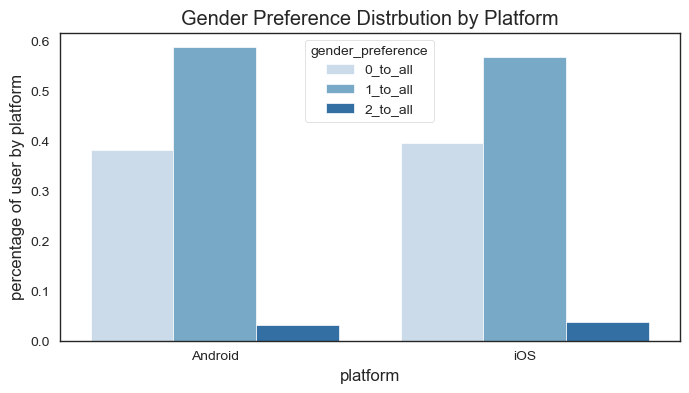

In [35]:
plt.figure(figsize=(8,4))
ax = sns.barplot(x = 'platform', y = 'value', 
            hue = 'gender_preference',
            data = gender_pref_df_vis,
           palette = 'Blues')
plt.ylabel('percentage of user by platform')
plt.title('Gender Preference Distrbution by Platform')

### 3.3 Other demographics data by platform

- Android and iOS have similar photos per user. They both have around 5 photos per user. 
- iOS users have 2 miles more in average max distance than Android users (58 - 56)
- The average age of Android and iOS are close, Android has an average age of 27 and iOS has average age of 28 
- Both Android and iOS users have 14 as their age preference range (`age_pref_max - age_pref_min`)
- Android users have average height as 174cm and iOS users have average height as 173cm
- They both have dogs and cats rating the same. Both Android and iOS users have average like rating of dogs as 1 and average like rating of cats as 2.


In [36]:
round(user_df.groupby('platform').mean())[['photos_count', 'max_distance', 'age', 'age_pref_max','age_pref_min',
                                          'height','dogs',	'cats']]

,photos_count,max_distance,age,age_pref_max,age_pref_min,height,dogs,cats
platform,,,,,,,,
Android,5.0,56.0,27.0,37.0,23.0,174.0,1.0,2.0
iOS,5.0,58.0,28.0,38.0,24.0,173.0,1.0,2.0


### 3.4 Users' education attained

- 46% of Android users have education level of 1, iOS users have 43% of users in education 1
- 23% of Android users have education 2, iOS users have 22% users in education 2, the percentage of users in education 2 are close
- iOS users have 22% users in education 3, which is 2% higher than Android's corresponding number (19%)
- Since education attained is nominal and higher number doesn't necessarily mean more education, it's hard to draw precious conclusions from education data. We can tell both Android and iOS users have similar distribution on education attained in general. 

In [37]:
user_df.education_attained = user_df.education_attained.astype('object')

edu_df = pd.DataFrame(user_df.groupby(['platform','education_attained']).nunique()['user_id'])

edu_df.reset_index(inplace=True)

edu_df_piv = pd.pivot_table(edu_df, values = 'user_id', index = 'platform', columns = ['education_attained'], 
               aggfunc = np.sum , margins=True)

In [38]:
edu_df_piv

education_attained,0.0,1.0,2.0,3.0,All
platform,,,,,
Android,8079,31128,15220,12810,67237
iOS,6224,18970,9717,9574,44485
All,14303,50098,24937,22384,111722


In [39]:
#calculate percentage of users in each education attained by platform
edu_df_piv['0 to all'] =edu_df_piv[0.0] / edu_df_piv['All']
edu_df_piv['1 to all'] =edu_df_piv[1.0] / edu_df_piv['All']
edu_df_piv['2 to all'] =edu_df_piv[2.0] / edu_df_piv['All']
edu_df_piv['3 to all'] =edu_df_piv[3.0] / edu_df_piv['All']

edu_df_piv.reset_index(inplace=True)

edu_df_vis = pd.melt(edu_df_piv, id_vars= 'platform', value_vars = ['0 to all', '1 to all', '2 to all',
       '3 to all'])

edu_df_vis = edu_df_vis[edu_df_vis.platform!='All']

edu_df_vis = round(edu_df_vis, 2)

Text(0.5, 1.0, 'Education Attained Distrbution by Platform')

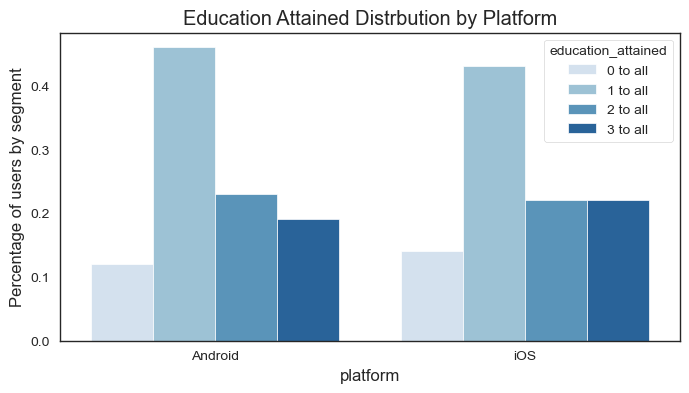

In [40]:
plt.figure(figsize=(8,4))
ax = sns.barplot(x = 'platform', y = 'value', 
            hue = 'education_attained',
            data = edu_df_vis,
           palette = 'Blues')

plt.ylabel('Percentage of users by segment', size='12')
plt.title('Education Attained Distrbution by Platform')

### 3.5 Behavioral data analysis - How long does it take from registration to profile completion for iOS and Android users?

- It takes 300 seconds per user from Android users complete their profile since registration, and 299 seconds for iOS users. 
- Android and iOS users have similar average seconds per user from registration to profile completion 

In [41]:
difference = user_df.profile_completion_ts- user_df.registration_ts

In [42]:
user_df['reg_com_diff'] = difference.dt.seconds

In [43]:
reg_com_diff_df = user_df[['user_id', 'platform', 'registration_ts', 'profile_completion_ts','reg_com_diff']]

In [44]:
reg_com_diff_df.groupby('platform').mean()

,user_id,reg_com_diff
platform,,
Android,126141.007362,300.451947
iOS,125815.363508,299.028908


### 3.6 Behavioral data analysis - In App Behavior

As In-app behavior can help us understand users' behavior across platform, I'd like to take a look at metrics from users' registration date to registration date + 48 hours (end of the next day conversion window) to coincide with Q2's retention rate calculation. 

Metrics: 
- `Number of likes and skips per user within the next day conversion window` by platform
- `Number of likes per user within the next day conversion window` by platform
- `Number of skips per user within the next day conversion window` by platform
- `Number of likes and skips per user within the next day conversion window` by retention indicator and platform 
- `Number of likes per user within the next day conversion window` by retention indicator and platform 
- `Number of skips per user within the next day conversion window` by retention indicator and platform 


**Findings**

- `Number of likes and skips per user within the next day conversion window by platform`
    - Android: 268
    - iOS: 275
    - iOS has higher likes and skips per user within the next day conversion window than Android
- `Number of likes per user within the next day conversion window by platform`
    - Android: 46
    - iOS: 48
    - iOS has higher likes per user than Android
- `Number of skips per user within the next day conversion window by platform`
    - Android: 228
    - iOS: 234
    - iOS has higher skips per user than Android

- `Number of likes and skips per user within the next day conversion window` by retention indicator and platform
    - Android Next-day retained users: 342
    - Android Next-day churned users: 78
    - iOS Next-day retained users: 357
    - iOS Next-day churned users: 80
    - iOS has higher number of likes and skips per user than Android even we group it by retained/churned users.
    
    </br>
    
- `Number of likes per user within the next day conversion window` by retention indicator and platform
    - Android Next-day retained users: 56
    - Android Next-day churned users: 18
    - iOS Next-day retained users: 59
    - iOS Next-day churned users: 19
    - iOS has higher number of likes per user than Android even we group it by retained/churned users
    
    </br>
- `Number of skips per user within the next day conversion window` by retention indicator and platform
    - Android Next-day retained users: 287 
    - Android Next-day churned users: 66
    - iOS Next-day retained users: 301
    - iOS Next-day churned users: 68
    - iOS has higher number of skips per user than Android even we group it by retained/churned users
    
    </br>
- Overall, Retained users have higher `Number of skips per user` , `Number of likes per user` and `Number of likes and skips per user`. If we compare metrics by platform, we see iOS has higher behavioral/engagement metrics than Android, which sounds counterintuitive from my conclusion in Q2 that Android has higher retention rate than iOS. In reality, I would collect more data to learn more about user behavior. 

In [45]:
user_registration_date = user_rating_df[['user_id', 'registration_ts']].groupby(by = ['user_id']).min().reset_index()

In [46]:
#we want to count users behavior b/w registration date and registration date + 48 hours 
user_registration_date['max_bound'] = user_registration_date['registration_ts'] + timedelta(hours = 48)

In [47]:
Day1_likes_df = pd.merge(user_registration_date, user_rating_df, how = 'left' , on ='user_id')[['user_id', 'registration_ts_x',
                                                                                'max_bound','platform',
                                                                               'rating_type','ts_minute','ct','Day1_active']]

In [48]:
#filter likes or skip event within the conversion time range

Day1_active_df = Day1_likes_df[(Day1_likes_df.ts_minute >= Day1_likes_df.registration_ts_x) & (Day1_likes_df.ts_minute <= Day1_likes_df.max_bound )]

`Number of likes and skips per user within the next day conversion window by platform`

In [49]:
round(Day1_active_df.groupby(['platform']).sum()['ct'] / Day1_active_df.groupby(['platform']).nunique()['user_id'])

platform
Android    268.0
iOS        275.0
dtype: float64

`Number of likes per user within the next day conversion window` by platform </br>
`Number of skips per user within the next day conversion window` by platform

In [50]:
#get number of count by platform 
round(Day1_active_df.groupby(['platform', 'rating_type']).sum()['ct'] / Day1_active_df.groupby(['platform', 'rating_type']).nunique()['user_id'])

platform  rating_type
Android   0.0            228.0
          1.0             46.0
iOS       0.0            234.0
          1.0             48.0
dtype: float64

**Metrics by retention indicator and platform**

In [51]:
#get number of count by platform 
Day1_active_agg = pd.DataFrame(Day1_active_df.groupby(['platform', 'rating_type', 'Day1_active']).sum()['ct'] / Day1_active_df.groupby(['platform', 'rating_type','Day1_active']).nunique()['user_id'])

In [52]:
Day1_active_agg.reset_index(inplace=True)

In [53]:
Day1_active_agg.columns

Index(['platform', 'rating_type', 'Day1_active', 0], dtype='object')

In [54]:
Day1_active_agg.rename(columns = {0:"Ratings per user"}, inplace=True)

In [55]:
Day1_active_agg.rename(columns = {'Day1_active':"Retention Indicator"}, inplace=True)

In [56]:
round(Day1_active_agg)

,platform,rating_type,Retention Indicator,Ratings per user
0,Android,0.0,0,66.0
1,Android,0.0,1,287.0
2,Android,1.0,0,18.0
3,Android,1.0,1,56.0
4,iOS,0.0,0,68.0
5,iOS,0.0,1,301.0
6,iOS,1.0,0,19.0
7,iOS,1.0,1,59.0


In [57]:
round(Day1_active_agg[Day1_active_agg.rating_type != 1.0])

,platform,rating_type,Retention Indicator,Ratings per user
0,Android,0.0,0,66.0
1,Android,0.0,1,287.0
4,iOS,0.0,0,68.0
5,iOS,0.0,1,301.0


In [58]:
round(pd.DataFrame(Day1_active_df.groupby(['platform', 'Day1_active']).sum()['ct'] / Day1_active_df.groupby(['platform','Day1_active']).nunique()['user_id']))

0
platform Day1_active       
Android  0             78.0
         1            342.0
iOS      0             80.0
         1            357.0

Text(0.5, 1.0, 'Number of Ratings Per User by Retained and Churned user')

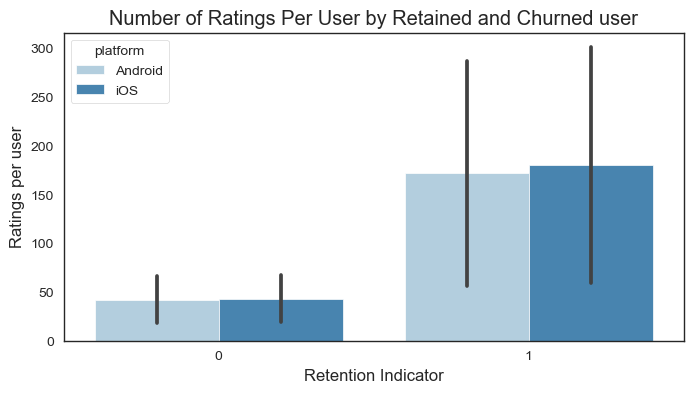

In [59]:
plt.figure(figsize=(8,4))

ax = sns.barplot(x = "Retention Indicator", y = 'Ratings per user', hue = 'platform', data =Day1_active_agg, palette = 'Blues' )
plt.title('Number of Ratings Per User by Retained and Churned user')

----
<a id='Question4'></a>
## Question 4 Design an experiment to improve the retention rate for all users. 
a. Your hypothesis </br>
b. A description of the variants of your experiment</br>
c. The primary outcomes you'll use to evaluate your experiment</br>
d. Any other information you think will be useful for your PM</br>


[[ go back to the top ]](#Table-of-contents)

**Step 1. Define the successful metric** 
</br>
Successful metric needs to be 100% correlated with business objective. Since we are designing an experiment to improve the retention rate for all users, our business objective is to improve the retention rate. So I'd recommend setting retention rate as the successful metric.
We also need to define guardrail metrics because it can help us understand the AB test performance holistically. I'd set user engagement metrics, app latency, app crashes, and revenue as guardrail metrics.
 </br>
- User engagement metrics should describe users' in-app engagement:
    - Number of events per user per session (Assume event means each in-app behavior users trigger, it could be likes or skips, or clicking any button in the app)
    - Number of sessions per user
    - Average Session time per user
    - Number of likes and skips per user
    - Number of likes per user
    - Number of skips per user


- Metrics measure app crashes, latency 
    - High latency affects user behavior and satisfaction, the higher the latency, the lower users satisfaction
    - App Crashes also need to be measured, we wanted to make sure the app works fine during the experiment

- Revenue
    - Revenue measures the health of the business earnings. 

**Step 2. Hypothesis Testing**
</br>
According to the EDA in Q3, I've found that retained users have a higher `Number of skips per user , Number of likes per user, and Number of likes and skips per user`. It seems like more likes per user, the higher the retention rate. So I'd like to design an AB test to test if increasing the size of the like icon would increase the retention rate for all users. (Increasing the size of the like icon would make it more obvious for users, so it could increase users' engagement)
</br>

I'd set the control as the current app version, and the variant has a larger like icon size, the rest of the design should stay identical between the control and variant.
</br>

**Null Hypothesis (H0)**: The retention rate between the control and variant are the same. </br>
**Alternative Hypothesis (Ha)**: The retention rate between the control and variant are different. </br>
</br>
**Set the significance level** </br>
Alpha = 0.05 </br>
Statistical Power= 0.8 </br>
MDE = 1%
Minimum detectable effect (MDE): when setting MDE, I'd extract past three months data as the baseline, and talk to the PM to see how much increase in retention rate do we expect. Let's assume the MDE in this experiment is 1%, so it means that if the change is at least 1% higher in retention rate then it's practially significant.  </br> 



**Step 3. Design the experiment** </br>
- Randomization Unit: we will use users as randomization unit. The AB testing platform should randomly assign new users to control and variant groups.  </br>

- Target population in the experiment: All Hinge new users who have completed their profiles and have reached the "Discover Screen" to view other users' profile. 
    - The reason for choosing new users is because it would eliminate novelty effect. And choosing users who have completed their profiles because I found only users who have completed profile are able to click likes or skips. I also wanted to make sure those users have reached the "Discover Screen" and view others' profile, otherwise, users who haven't viewed others' profile will be counted and dilute the successful metrics.</br>

- Determine the sample size: we can use n = 16 * sample variance /delta to calculate the minimum sample size. In reality, we should always consider weekly effect, so running 1 to 2 weeks (whole weeks) is recommended.

**Step 4. Run the experiment** </br>
After the experiment runs, I'd suggest to PM do not peek at p-values during the experiment because it would increase false positive rate. I'd suggest to the PM to look at the data after the experiment ends. 

**Step 5. Validity Checks** </br>
After the experiment, I'd check guardrail metrics and see if anything is alarming. What's more, checking if there are holidays, compeitition, economic disruptions etc. </br>
Also, Data scientist should run Sample ratio mismatch test to make sure no mismatch between the expected sample ratio and observed sample ratio. 

**Step 6. Interpret result and launch descision** </br>
After the validity checks, we could extract the control and variant success metrics by group and compare them, we can calculate `Absolute difference` , `Relative Difference` and get its p-value through a statistical test. A p-value lower than alpha (0.05) means we are confident to reject the null hypothesis and conclude that the retention rate between control and variant are different. </br>

After that, we should talk to PM and engineering team to understand if the costs are high for launching the change. Costs include the cost to build the feature and the cost for ongoing engineering maintenance. </br>

- When costs are high, the benefit of launching the change should outweigh the cost. 
- When costs are low, as long as we are confident to reject the null hypothesis, we should launch any positive changes.  